In [186]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [187]:
%pip install pydlm

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [188]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [189]:
%pip install openpyxl


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [190]:
%pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [192]:
#import data
df = pd.read_csv('../Datasets/AMD Historical Data.csv')

#print data 
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,1/3/2017,11.43,11.42,11.65,11.02,55.18M,0.79%
1,1/4/2017,11.43,11.45,11.52,11.23,40.78M,0.00%
2,1/5/2017,11.24,11.43,11.69,11.23,38.86M,-1.66%
3,1/6/2017,11.32,11.29,11.49,11.11,34.45M,0.71%
4,1/9/2017,11.49,11.37,11.64,11.31,37.30M,1.50%


In [193]:
#Bỏ dòng bị trống dự liệu
df = df.dropna()
#Chuyển đổi dữ liệu cột Vol. sang số
df['Vol.'] = df['Vol.'].str.replace('M', '').astype(float) * 1000000
#Chuyển đổi cột 'Change %' từ kiểu dữ liệu object sang kiểu dữ liệu float64
df['Change %'] = df['Change %'].str.rstrip('%').astype(float)



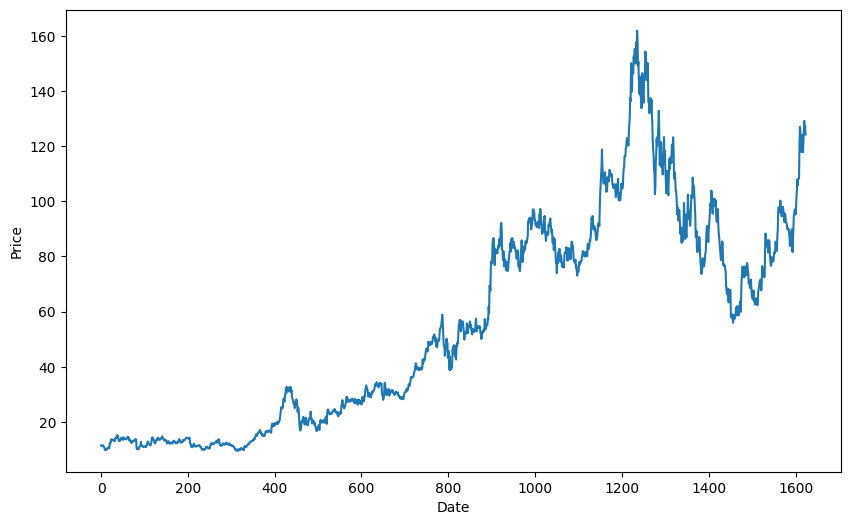

In [194]:
figure=df['Price'].values
plt.figure(figsize=(10,6))
plt.plot(figure)
plt.xlabel('Date')
plt.ylabel('Price') 
plt.show()

In [195]:
#Xây dựng mô hỉnh với Bayesian Dynamic Linear Model
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason


In [196]:
df = df.reset_index(drop=True)
 # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [197]:
#Tính toán độ tương quan để biết cột nào có ảnh hưởng tới cột Price nhất
correlations = df.drop('Date', axis=1).corr()['Price']
most_influential_columns = correlations.drop('Price').nlargest(3).index.tolist()
most_influential_columns

['High', 'Low', 'Open']

In [198]:
from pydlm import dlm, trend, seasonality

# Tạo model DLM
my_dlm = dlm(train_data['Price'])

# Thêm trend component
my_dlm = my_dlm + trend(degree=2, name='trend', w=1e7)

# # Thêm seasonality component với chu kỳ 52 ngày
my_dlm = my_dlm + seasonality(period=30, name='season', w=1e7)


#Tạo một danh sách các danh sách, trong đó mỗi phần tử là một giá trị của cột 'Open' trong DataFrame
dynamic_features_Open = [[value] for value in df['Open'].values]
#Lấy đúng size theo train_data
train_dynamic_Open = dynamic_features_Open[:train_size]
my_dlm = my_dlm + dynamic(features=train_dynamic_Open, name='dynamicOpen', discount=0.99, w=1e7)

#Tạo một danh sách các danh sách, trong đó mỗi phần tử là một giá trị của cột 'High' trong DataFrame
dynamic_features_High = [[value] for value in df['High'].values]
#Lấy đúng size theo train_data
train_dynamic_High = dynamic_features_High[:train_size]
my_dlm = my_dlm + dynamic(features=train_dynamic_High, name='dynamicHigh', discount=0.99, w=1e7)

#Tạo một danh sách các danh sách, trong đó mỗi phần tử là một giá trị của cột 'Low' trong DataFrame
dynamic_features_Low = [[value] for value in df['Low'].values]
#Lấy đúng size theo train_data
train_dynamic_Low = dynamic_features_Low[:train_size]
my_dlm = my_dlm + dynamic(features=train_dynamic_Low, name='dynamicLow', discount=0.99, w=1e7)

# Thêm autoregressive component với độ lệch (degree) là 3
my_dlm = my_dlm + autoReg(degree=3, discount=0.99, name='ar3', w=1e7)


# #Tạo một danh sách các danh sách, trong đó mỗi phần tử là một giá trị của cột 'Vol.' trong DataFrame
# dynamic_features_Vol = [[value] for value in df['Vol.'].values]
# #Lấy đúng size theo train_data
# train_dynamic_Vol = dynamic_features_Vol[:train_size]
# my_dlm = my_dlm + dynamic(features=train_dynamic_Vol, name='dynamicVol', discount=0.95)

# #Tạo một danh sách các danh sách, trong đó mỗi phần tử là một giá trị của cột 'Change' trong DataFrame
# dynamic_features_Change = [[value] for value in df['Change %'].values]
# #Lấy đúng size theo train_data
# train_dynamic_Change = dynamic_features_Change[:train_size]
# my_dlm = my_dlm + dynamic(features=train_dynamic_Change, name='dynamicChange', discount=0.95)


# #Tạo một danh sách các danh sách, trong đó mỗi phần tử là một giá trị của cột 'High' trong DataFrame
# dynamic_features_Price = [[value] for value in df['Price'].values]
# #Lấy đúng size theo train_data
# train_dynamic_Price = dynamic_features_Price[:train_size]
# my_dlm = my_dlm + dynamic(features=train_dynamic_Price, name='dynamicPrice', discount=0.95)


In [199]:

# Fit the DLM to the training data
my_dlm.fit()


Initializing models...
Initialization finished.
Starting forward filtering...


Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [200]:
# Tạo featureDict cho dự đoán
featureDict = {
    'dynamicOpen': train_dynamic_Open,
    'dynamicHigh': train_dynamic_High,
    'dynamicLow': train_dynamic_Low,
    # 'dynamicVol': train_dynamic_Vol,
    # 'dynamicChange': train_dynamic_Change
}

# featureDict = {
#     'dynamicPrice': train_dynamic_Price,
# }

In [201]:

# Predict on test data
test_preds, test_vars = my_dlm.predictN(N=test_size, featureDict=featureDict)

In [202]:
my_dlm.append(test_preds, component='main')


Remember to append the new features for the dynamic components as well


In [203]:
test_dynamic_features_Open = dynamic_features_Open[:test_size]


test_dynamic_features_High = dynamic_features_Open[:test_size]

test_dynamic_features_Low = dynamic_features_Open[:test_size]


In [204]:
# Cập nhật dynamic component nếu có
my_dlm.append(data=test_dynamic_features_Open, component='dynamicOpen')
my_dlm.append(data=test_dynamic_features_High, component='dynamicHigh')
my_dlm.append(data=test_dynamic_features_Low, component='dynamicLow')

In [205]:
my_dlm.fit()


Starting forward filtering...


Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [206]:
# Predict on validation data
val_preds, val_vars = my_dlm.predictN(N=val_size, featureDict=featureDict)

In [207]:
my_dlm.append(val_preds, component='main')
val_dynamic_features_Open = dynamic_features_Open[:val_size]

val_dynamic_features_High = dynamic_features_Open[:val_size]

val_dynamic_features_Low = dynamic_features_Open[:val_size]
# Cập nhật dynamic component nếu có
my_dlm.append(data=val_dynamic_features_Open, component='dynamicOpen')
my_dlm.append(data=val_dynamic_features_High, component='dynamicHigh')
my_dlm.append(data=val_dynamic_features_Low, component='dynamicLow')
my_dlm.fit()

Remember to append the new features for the dynamic components as well
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...


Backward smoothing completed.


In [208]:
# Các giá trị thực tế cho validation, test và train data
val_actual = val_data['Price'].values
test_actual = test_data['Price'].values
train_actual = train_data['Price'].values

In [209]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error

# Regression metrics
test_rmse = np.sqrt(np.mean((test_preds - test_actual)**2))
test_mse = mean_squared_error(test_actual, test_preds)
test_mae = mean_absolute_error(test_actual, test_preds)

valid_rmse = np.sqrt(np.mean((val_preds - val_actual)**2))
valid_mse = mean_squared_error(val_actual, val_preds)
valid_mae = mean_absolute_error(val_actual, val_preds)

print('Testing RMSE:', test_rmse)
print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)

print('Validation RMSE:', valid_rmse)
print('Validation MSE:', valid_mse)
print('Validation MAE:', valid_mae)

Testing RMSE: 74.3207094009304
Testing MSE: 5523.567845857543
Testing MAE: 70.01366153763384
Validation RMSE: 40.09873641158777
Validation MSE: 1607.9086618059948
Validation MAE: 37.24258073130196


In [210]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

In [211]:
# Dự đoán 30 ngày tiếp theo sau tập validation
future_preds, future_vars = my_dlm.predictN(N=30, featureDict=featureDict)

# In ra dự đoán cho 30 ngày tiếp theo
print("Predictions for the next 30 days:")
print(future_preds)

Predictions for the next 30 days:
[51.39742666561584, 51.62469499974682, 51.952495100873186, 52.17518653935701, 52.0315809739005, 52.07859316842341, 52.05744179840564, 51.93762346557676, 52.2697721447404, 52.3173436037598, 52.77467733870607, 52.657829171359154, 52.34293977398403, 52.73261750836079, 52.94669118613021, 52.86568050153163, 52.71813528431548, 53.772304053936125, 52.97207200496682, 53.27450075831018, 53.63933161899129, 53.7096623759092, 53.139365816973886, 54.20049561293317, 53.22569325023088, 54.34349504459874, 53.46202407571394, 53.84238185325721, 54.014454338145015, 54.25597595536989]


In [212]:
#Tạo một mảng chứa toàn bộ dữ liệu của tập train, validation và test
allPreds = np.concatenate([train_preds,test_preds, val_preds])


In [213]:
#Tạo mảng index tương ứng với tập allPreds
days = np.arange(0, len(allPreds))


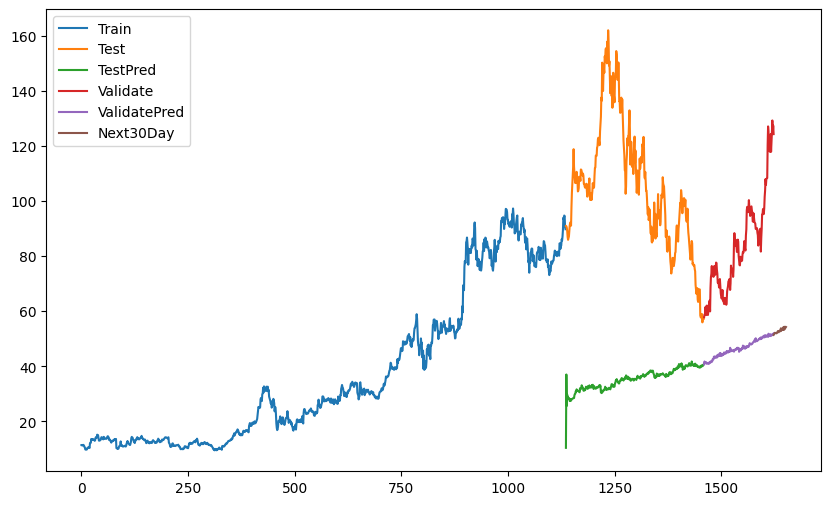

In [214]:
#Vẽ hình
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(days[len(train_data.index):len(train_data.index)+len(test_preds)], test_preds, label='Prediction')
plt.plot(val_data.index, val_data['Price'])
plt.plot(days[len(train_data.index)+len(test_preds):], val_preds, label='Validate')
plt.plot(last_data,future_preds, label='Next30Day')

#plt.plot(pred_df.index, pred_df['Price'], label='Predicted')
plt.legend(['Train', 'Test', 'TestPred', 'Validate', 'ValidatePred', 'Next30Day'])
plt.show()